In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import healpy as hp
import numpy as np

import sys
sys.path.append('/home/mehdi/github/LSSutils')
import LSSutils.utils as utils
from LSSutils.dataviz import mycolor

camb is not installed!


In [2]:
plt.rc('font', size=15)

In [3]:
path = '/C/sheejong/Shared/Shadab/'

# Run 2

In [11]:
area1pix   = hp.nside2pixarea(512, degrees=True)/3282.8  # steradians            

def get_cl(delta_ngal, ranmap, mask, lmax=1024):
    """ uses healpy.anafast to compute the C_ell
    """
    map_i  = hp.ma(ranmap.astype('f8')) 
    map_i.mask = np.logical_not(mask) 
    clmask = hp.anafast(map_i.filled(), lmax=lmax)
    sf = ((2*np.arange(clmask.size)+1)*clmask).sum()/(4.*np.pi)

    map_ngal       = hp.ma(delta_ngal * ranmap)
    map_ngal.mask  = np.logical_not(mask)
    cl_auto        = hp.anafast(map_ngal.filled(), lmax=lmax) / sf
    return cl_auto

class Cell(object):
    
    def __init__(self, galaxy, mask):
        full = np.loadtxt(galaxy)
        self.galaxy = hp.reorder(full, n2r=True)
        
        mask_full = np.load(mask, allow_pickle=True)['mask']
        mask_full = hp.reorder(mask_full, n2r=True)
        self.mask = mask_full > 0.0 #.astype('f8')
        self.comp = np.ones_like(self.galaxy) # no randoms
    
    def __call__(self, mask=None, lmax=1024):
        self._anafast(mask, lmax)
        
    def _anafast(self, mask=None, lmax=None):
        global area1pix
        if mask is None:mask=self.mask
        self.delta = utils.makedelta(self.galaxy, 
                                     self.comp, 
                                     mask)                
        self.cell   = get_cl(self.delta, self.comp, mask, lmax)
        self.snoise = mask.sum()/self.galaxy[mask].sum() * area1pix

In [12]:
full = Cell('/C/sheejong/Shared/Shadab/full-mock100-hpmap-nside-512.txt',
           '/C/sheejong/Shared/Shadab/full_v0.0-nside-512-nested.mask')

In [14]:
sub = Cell('/C/sheejong/Shared/Shadab/sub-mock100-hpmap-nside-512.txt',
           '/C/sheejong/Shared/Shadab/sub_v0.0-nside-512-nested.mask')

In [24]:
cell_full_full = (full.cell-full.snoise).copy()
cell_sub_full = (sub.cell-sub.snoise).copy()

/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/healpy/projaxes.py:1196: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/healpy/projaxes.py:1155: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):


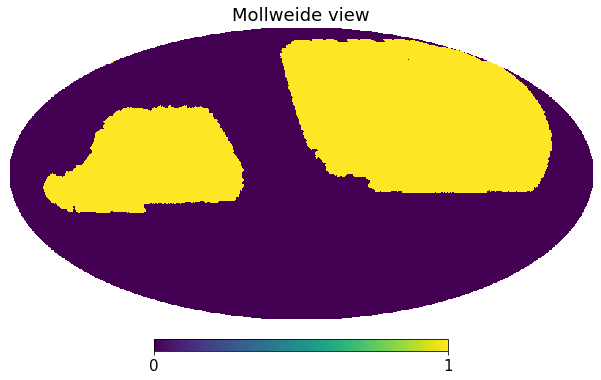

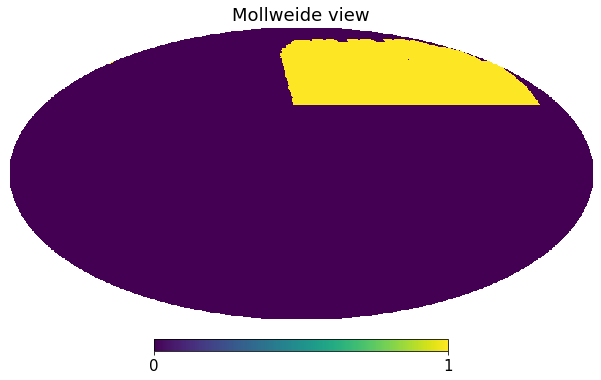

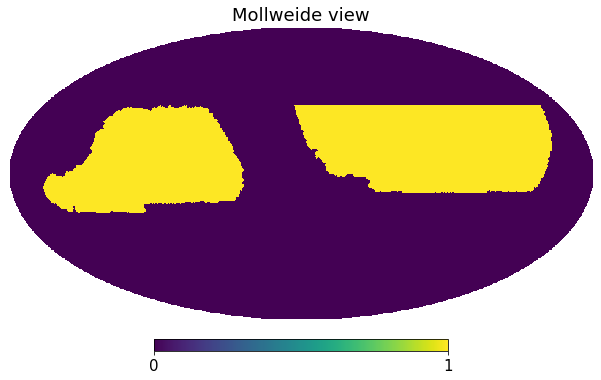

In [43]:
# find MzLS/BASS
_,dec = utils.hpix2radec(512, np.arange(12*512*512))
mask_full   = full.mask & sub.mask 
mask_MzLS   = full.mask & sub.mask & (dec > 34.7) #http://legacysurvey.org/dr8/description/
mask_decals = full.mask & sub.mask & (~mask_MzLS)
hp.mollview(mask_full, rot=-89)
hp.mollview(mask_MzLS, rot=-89)
hp.mollview(mask_decals, rot=-89)

In [45]:
cells = {}
names = ['Combined', 'DECaLS', 'MzLS/BASS']
for i, mask_i in enumerate([mask_full, mask_decals, mask_MzLS]):
    full(mask=mask_i)
    sub(mask=mask_i)
    cells[names[i]] = {'full':(full.cell-full.snoise).copy(),
                       'sub':(sub.cell-sub.snoise).copy()}

Combined
DECaLS
MzLS/BASS


[(1e-08, 0.01), Text(0, 0.5, '$C_{\\ell}$'), Text(0.5, 0, '$\\ell$')]

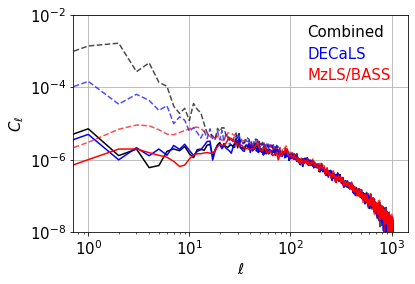

In [54]:
ell = np.arange(1025)
colors = ['k', 'b', 'r']
fig, ax = plt.subplots()
for i,k in enumerate(cells.keys()):
    print(k)
    mypart = cells[k]
    cl_full = mypart['full']
    cl_sub  = mypart['sub']
    ax.plot(ell, cl_full, '-', color=colors[i])
    ax.plot(ell, cl_sub, '--', alpha=0.7, color=colors[i])
    ax.text(0.7, 0.9-i*0.1, k, color=colors[i], transform=ax.transAxes)
ax.loglog()
ax.grid(True)
ax.set(xlabel=r'$\ell$', ylabel=r'$C_{\ell}$', ylim=(1.e-8, 1.e-2))

# Run 1

READ the data

In [4]:
full = np.loadtxt(path + 'full-mock100-hpmap-nside-512.txt')
full = hp.reorder(full, n2r=True)

mask_full = np.load(path + 'full_v0.0-nside-512-nested.mask', allow_pickle=True)['mask']
mask_full = hp.reorder(mask_full, n2r=True)

sub = np.loadtxt(path + 'sub-mock100-hpmap-nside-512.txt')
sub = hp.reorder(sub, n2r=True)

mask_sub = np.load(path + 'sub_v0.0-nside-512-nested.mask', allow_pickle=True)['mask']
mask_sub = hp.reorder(mask_sub, n2r=True)

/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/healpy/projaxes.py:1196: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/healpy/projaxes.py:1155: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):


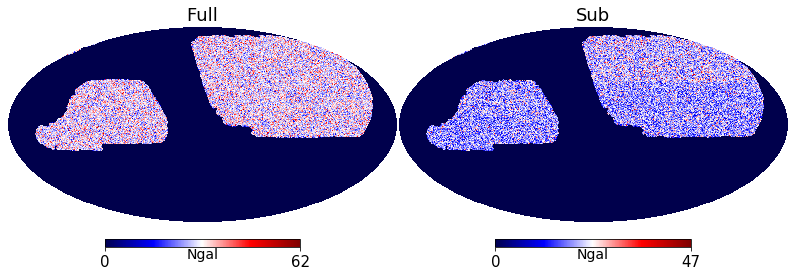

In [5]:
fig, ax = plt.subplots(ncols=2, figsize=(14, 6))
fig.subplots_adjust(wspace=0)
kw = dict(hold=True, rot=-85, cmap=plt.cm.seismic, unit='Ngal')
fig.sca(ax[0])
hp.mollview(full, **kw, title='Full')
fig.sca(ax[1])
hp.mollview(sub, **kw, title='Sub')
plt.show()

Create Fracgood maps

In [6]:
MASK = (mask_full > 0.) & (mask_sub > 0.) # if you comment out the second part, the constant offset appears
weight_full = mask_full/mask_full[MASK].mean()
weight_sub  = mask_sub/mask_sub[MASK].mean()

In [7]:
area1pix= hp.nside2pixarea(512, degrees=True)/3282.8  # steradians
sn_full = weight_full[MASK].sum() / full[MASK].sum()  *area1pix
sn_sub  = weight_sub[MASK].sum()  / sub[MASK].sum()    *area1pix

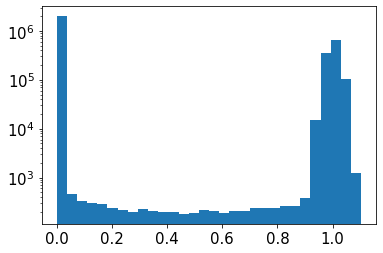

In [8]:
plt.hist(weight_full, bins=30)
plt.yscale('log')

In [9]:
comp = np.ones_like(full)
delta_full = utils.makedelta(full, comp, MASK)
delta_sub  = utils.makedelta(sub,  comp,  MASK)

In [10]:
sn_full, sn_sub

(1.3233407354861509e-07, 2.0271868479147446e-07)

In [11]:
def get_cl(delta_ngal, ranmap, mask, lmax=1024):
    """ uses healpy.anafast to compute the C_ell
    """
    map_i  = hp.ma(ranmap.astype('f8')) 
    map_i.mask = np.logical_not(mask) 
    clmask = hp.anafast(map_i.filled(), lmax=lmax)
    sf = ((2*np.arange(clmask.size)+1)*clmask).sum()/(4.*np.pi)

    map_ngal       = hp.ma(delta_ngal * ranmap)
    map_ngal.mask  = np.logical_not(mask)
    cl_auto        = hp.anafast(map_ngal.filled(), lmax=lmax) / sf
    return cl_auto

In [12]:
cl_full = get_cl(delta_full, comp,  MASK)
cl_sub  = get_cl(delta_sub,  comp,  MASK)

/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/healpy/pixelfunc.py:345: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/healpy/projaxes.py:1176: RuntimeWarning: invalid value encountered in less
  result.data[result.data < 0] = 0.0
/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/healpy/projaxes.py:1177: RuntimeWarning: invalid value encountered in greater
  result.data[result.data > 1] = 1.0


[(0.2, 1.8),
 Text(517.2340909090908, 0.5, 'C$^{sub}_{\\ell}$/C$^{full}_{\\ell}$'),
 Text(0.5, 64.00000000000009, '$\\ell$')]

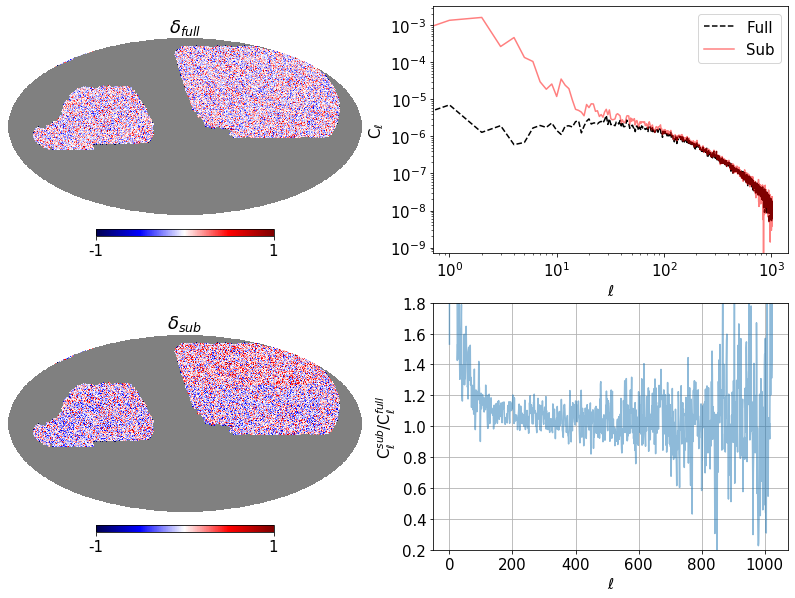

In [13]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(14, 10))
ax = ax.flatten()
fig.subplots_adjust(wspace=0.2)
kw = dict(hold=True, rot=-85, min=-1, max=1., cmap=plt.cm.seismic, cbar=True)
fig.sca(ax[0])
hp.mollview(delta_full, **kw, title=r'$\delta_{full}$')
fig.sca(ax[2])
hp.mollview(delta_sub, **kw, title=r'$\delta_{sub}$')



#fig, ax = plt.subplots(nrows=2, figsize=(8, 12))

el = np.arange(cl_full.size)
ax[1].plot(el, cl_full-1.0*(sn_full), 'k--', label='Full')
ax[1].plot(el, cl_sub-1.0*(sn_sub), color='r', alpha=0.5, label='Sub')
ax[1].loglog()
ax[1].legend()
#ax[0].set_yscale('log')
#plt.yscale('log')
#ax[0].set_ylim(1.e-8, 1.e-5)
ax[1].set(ylabel=r'C$_{\ell}$', xlabel=r'$\ell$')


ax[3].plot(el, (cl_sub-1.0*(sn_sub))/(cl_full-1.0*(sn_full)), alpha=0.5)
ax[3].grid(True)
ax[3].set(ylabel=r'C$^{sub}_{\ell}$/C$^{full}_{\ell}$',
          xlabel=r'$\ell$',
          ylim=(0.2, 1.8))